<a href="https://colab.research.google.com/github/WickedSero/NeuralNetworks/blob/main/2a_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieci splotowe (Convolutional Neural Networks)

In [ ]:
!pip install matplotlib numpy torch torchvision

  Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl.metadata (5.8 kB)
  Using cached torch-2.4.1-cp38-cp38-win_amd64.whl.metadata (27 kB)
  Using cached contourpy-1.1.1-cp38-cp38-win_amd64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.55.3-cp38-cp38-win_amd64.whl.metadata (168 kB)
  Using cached kiwisolver-1.4.7-cp38-cp38-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-10.4.0-cp38-cp38-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.1-py3-none-any.whl.metadata (5.3 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached matplotlib-3.7.5-cp38-cp38-win_amd64.whl (7.5 MB)
Using cached torch-2.4.1-cp38-cp38-win_amd64.whl (199

In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

### Przygotowanie danych
Wykorzystamy w zadaniu zbiór Fashion-MNIST. Jak zwykle zaczynamy od pobrania danych, sprawdzamy krótko jak wyglądają, a następnie definiujemy miarę trafności

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST

target_directory = "fmnist"

fmnist_real_train = FashionMNIST(target_directory, train=True, download=True, transform=transforms.ToTensor())
fmnist_test = FashionMNIST(target_directory, train=False, download=True, transform=transforms.ToTensor())

100.0%


Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



100.0%


Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100.0%

Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



In [ ]:
fmnist_train, fmnist_validation = data.random_split(fmnist_real_train, (48000, 12000))
len(fmnist_train), len(fmnist_validation)

(48000, 12000)

In [ ]:
fmnist_train[0][0].shape

torch.Size([1, 28, 28])

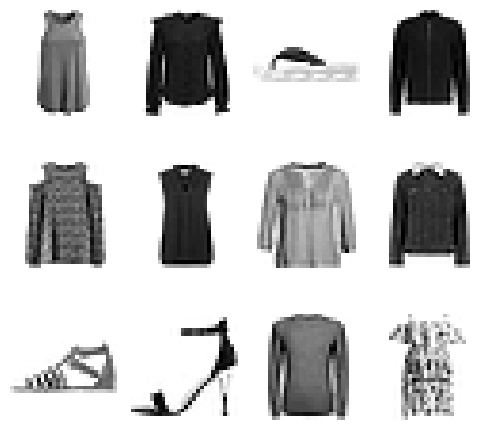

In [ ]:
trainloader = data.DataLoader(fmnist_train, batch_size=64, shuffle=True)
dataiter = iter(trainloader)
images,_ = next(dataiter)
plt.figure(figsize=(5,5))
for k in range(12):
    plt.subplot(3, 4, k+1)
    plt.imshow(images[k].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

#### Warstwa splotowa (konwolucyjna)

Warstwa splotowa przemieszcza jądro (ang. *kernel*), zwane też filtrem, po obrazie kawałek po kawałku, oblicza wynik i zapamiętuje go w macierzy wyjściowej. Przetwarzany obrazek jest często uzupełniany o zera (ang. *padding*), ponieważ bez tego macierz wynikowa byłaby mniejsza niż obrazek wejściowy. Piksel w macierzy wyjściowej obliczany jest następująco: każdy z pikseli obrazu wejściowego jest mnożony przez odpowiadającą mu wartość w filtrze, a tak uzyskane 9 wartości jest sumowane. Następnie ten sam filtr wykorzystywany jest do obliczenia kolejnego piksela. Filtr składa się z wag splotowej sieci neuronowej, co oznacza, że to on podlega uczeniu.

Jądro nie musi przesuwać się za każdym razem o 1 piksel, może mieć większy krok (ang. *stride*).

Jeśli obrazek jest kolorowy możemy go postrzegać jako kilka obrazków monochromatycznych.

Przykład: [jak działa sieć konwolucyjna](https://bfirst.tech/wp-content/uploads/2022/01/gif_blog.gif)

Warstwę splotową w PyTorch realizuje klasa [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#torch.nn.Conv2d). Pierwsze jej trzy parametry są obowiązkowe, są to:

- liczba map na wejściu,
- liczba map na wyjściu,
- rozmiar jądra (jedna liczba jeżeli ma być kwadratowe albo para liczb jeżeli ma być prostokątem).

Będziemy budowali krok po kroku listę, w której będziemy umieszczali kolejne warstwy sieci.

Rozpoczniemy od dodania warstwy splotowej.

Obrazki MNIST są monochromatyczne, więc mamy tylko 1 kanał wejściowy.

Przyjmimy, że na wyjściu będziemy mieli **5 map**, każdą na bazie kwadratowego filtra o boku 3.
Żeby nie zmniejszyć zbyt szybko obrazka dodamy po 1 pikselu paddingu z każdej strony - jak w ww. przykładzie.

In [ ]:
layers = [nn.Conv2d(1, 5, 3, padding=1)]

Warstwa splotowa - podobnie jak warstwa liniowa (`nn.Linear`) - jest tylko sumą. By wprowadzić nieliniowość, zastosujemy *Leaky ReLU*

In [ ]:
layers.append(nn.LeakyReLU())

Druga warstwa jest nazywana łączącą (ang. *pooling layer*). Jej zadaniem jest zmniejszenie wymiarów cech konwolucyjnych, wyznaczonych w poprzedniej warstwie, przy zachowaniu kluczowych szczegółów. Odpowiada również za redukcję szumu.

Warstwa ta, podobnie jak warstwa splotowa przesuwa filtr przez obraz, ale ten filtr jest pozbawiony parametrów: służy albo do wybierania maksimum (ang. *max pooling*) albo do obliczania średniej arytmetycznej (ang. *average pooling*). Każda mapa analizowana jest oddzielnie, więc zawsze pozostajemy w dwóch wymiarach.

Kontynuacja przykładu: [jak działa pooling](https://bfirst.tech/wp-content/uploads/2022/01/blog_konwolucyjne_sieci33.svg)

Dodamy zatem do naszej sieci neuronowej *max pooling*, realizowany za pomocą klasy `nn.MaxPool2d`, z jądrem rozmiaru $3 x 3$ i uzupełnieniem o 1 piksel z każdej strony.

In [ ]:
layers.append(nn.MaxPool2d(3, padding=1))

**Zadanie 1a. Mamy 5 map, a jakiego rozmiaru będą one na tym etapie przetwarzania, jeżeli wejście miało mapę rozmiaru $28 x 28$, a jądro ma rozmiar 3 z krokiem 3?**

Każda z 5 map na wyjściu będzie miała rozmiar 9x9

### Spłaszczenie i klasyfikacja

Na tym etapie każdy obiekt przetwarzany przez sieć jest trójwymiarowy, czyli składa się z pewnej liczby dwuwymiarowych map. Do klasyfikacji wykorzystamy sumującą warstwę liniową `nn.Linear`. Nie jest to dla niej odpowiedni format wejścia. Zatem najpierw za pomocą klasy `nn.Flatten` ułożymy piksele jeden za drugim w wektor.

**Zadanie 1b. Klasyfikujemy do 10 klas, więc mamy 10 neuronów wyjściowych, a ilu potrzeba wejść? Uzupełnij kod (w miejscu ...) na podstawie wyników zad. 1.**

In [ ]:
layers.append(torch.nn.Flatten())
layers.append(nn.Linear(500, 10))

### Konfiguracja sieci

**Zadanie 1c. Połącz gotowe warstwy w jeden sekwencyjny moduł, jako funkcję straty zadeklaruj entropię krzyżową/skrośną, a do optymalizacji parametrów modelu użyj optymalizatora Adam.**

In [ ]:
# Definicja warstw modelu
layers = [
    nn.Conv2d(1, 5, 3, padding=1),  # Warstwa konwolucyjna
    nn.LeakyReLU(),                # Aktywacja
    nn.MaxPool2d(3, padding=1),    # Warstwa łącząca (MaxPooling)
    nn.Flatten(),            # Spłaszczenie
    nn.Linear(500, 10)             # Warstwa liniowa do klasyfikacji
]

# Połączenie warstw w sekwencyjny moduł
model = nn.Sequential(*layers)

# Funkcja kosztu: entropia krzyżowa
cost = nn.CrossEntropyLoss()

# Optymalizator: Adam
opt = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
model

Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=500, out_features=10, bias=True)
)

### Uczenie z wykorzystaniem wczesnego zatrzymania

Wczesne zatrzymanie (ang. *early stopping*) składa się z następujących kroków:
- co określoną liczbę epok uczenia obliczamy miarę oceny (np. trafność klasyfikacji) na zbiorze walidującym
- jeżeli nastąpiła poprawa w stosunku do poprzedniego razu, zapamiętujemy obecne wartości wag sieci neuronowej
- jeżeli przez określoną liczbę epok nie następuje poprawa, przerywamy uczenie i przywracamy wagi ostatniego najlepszego modelu

**Zadanie 2a. Poniższy kawałek kodu oblicza trafność na zbiorze walidującym co epokę. Dodaj kod przerywający uczenie, jeżeli przez 5 kolejnych epok nie nastąpiła poprawa. Wyświetlaj wynik i numer porządkowy aktualnie najlepszej epoki, skorzystaj z zadeklarowanych zmiennych, podaj informację o fakcie wczesnego zatrzymania. Pamiętaj że najlepszy model powinien zostać zapisany, sprawdź w dokumentacji biblioteki pytorch jak to zrobić (jest to funkcja modelu). Na końcu ładujemy najlepszy model.**

In [ ]:
train_loss = []
validation_acc = []
best_model = None
best_acc = 0  # Początkowa wartość najlepszej trafności
best_epoch = 0
max_epoch = 10000
no_improvement = 5  # Liczba epok bez poprawy przed zatrzymaniem
batch_size = 512
patience_counter = 0  # Licznik epok bez poprawy

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(fmnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []

    # Trening modelu
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())

    # Walidacja
    model.eval()
    loader = data.DataLoader(fmnist_validation, batch_size=len(fmnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)

    # Sprawdzanie poprawy trafności
    if acc > best_acc:
        best_acc = acc
        best_epoch = n_epoch
        best_model = model.state_dict()  # Zapis stanu najlepszego modelu
        patience_counter = 0  # Resetowanie licznika cierpliwości
        print(f"Nowa najlepsza trafność: {best_acc:.4f} w epoce {best_epoch}")
    else:
        patience_counter += 1
        print(f"Brak poprawy przez {patience_counter} epok")

    # Wczesne zatrzymanie
    if patience_counter >= no_improvement:
        print(f"Wczesne zatrzymanie! Najlepsza trafność: {best_acc:.4f} w epoce {best_epoch}")
        break

# Załadowanie najlepszego modelu
model.load_state_dict(best_model)
print(f"Załadowano najlepszy model z epoki {best_epoch} o trafności {best_acc:.4f}")


Nowa najlepsza trafność: 0.7575 w epoce 0
Nowa najlepsza trafność: 0.7952 w epoce 1
Nowa najlepsza trafność: 0.8216 w epoce 2
Nowa najlepsza trafność: 0.8354 w epoce 3
Nowa najlepsza trafność: 0.8447 w epoce 4
Nowa najlepsza trafność: 0.8477 w epoce 5
Nowa najlepsza trafność: 0.8561 w epoce 6
Nowa najlepsza trafność: 0.8597 w epoce 7
Nowa najlepsza trafność: 0.8625 w epoce 8
Nowa najlepsza trafność: 0.8661 w epoce 9
Nowa najlepsza trafność: 0.8699 w epoce 10
Nowa najlepsza trafność: 0.8708 w epoce 11
Nowa najlepsza trafność: 0.8733 w epoce 12
Nowa najlepsza trafność: 0.8734 w epoce 13
Nowa najlepsza trafność: 0.8740 w epoce 14
Nowa najlepsza trafność: 0.8756 w epoce 15
Nowa najlepsza trafność: 0.8766 w epoce 16
Nowa najlepsza trafność: 0.8781 w epoce 17
Brak poprawy przez 1 epok
Nowa najlepsza trafność: 0.8798 w epoce 19
Nowa najlepsza trafność: 0.8801 w epoce 20
Nowa najlepsza trafność: 0.8802 w epoce 21
Nowa najlepsza trafność: 0.8808 w epoce 22
Nowa najlepsza trafność: 0.8817 w epoc

Przyjrzyj się poniższym wykresom

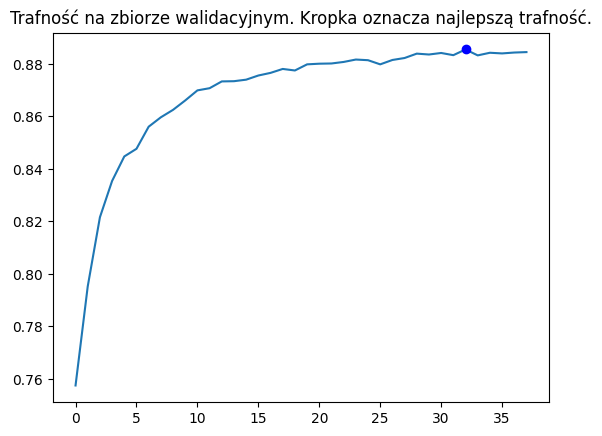

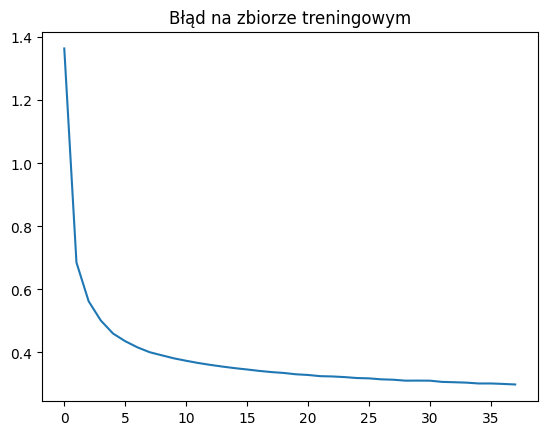

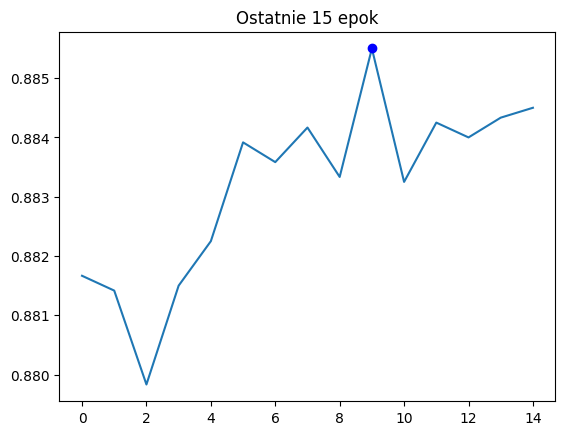

In [ ]:
plt.title('Trafność na zbiorze walidacyjnym. Kropka oznacza najlepszą trafność.')
plt.plot(validation_acc, label='Trafność na zbiorze walidacyjnym')
plt.plot(best_epoch, best_acc, 'bo', label='Najlepsza trafność')
plt.show()
plt.title('Błąd na zbiorze treningowym')
plt.plot(train_loss)
plt.show()
k = max(3*no_improvement, 0)
plt.title('Ostatnie {} epok'.format(k))
plt.plot(validation_acc[-k:])
plt.plot(best_epoch-(len(validation_acc)-k), best_acc, 'bo')
plt.show()

**Zadanie 2b. Dlaczego wczesne zatrzymanie jest realizowane na zbiorze walidującym, a nie na zbiorze uczącym albo na zbiorze testowym?**

Ponieważ zbiór testowy należy wykorzystać dopiero po zakończonym treningu modelu, a nie w trakcie uczenia się. Dlatego do wczesnego zatrzymania wykorzystujemy zbiór walidacyjny.